### 베이징 미세먼지 예측하기(회귀)
- 시계열 데이터 회득 및 전처리 pandas
- RNN 모델링 tensorflow

## 작업순서
1. 데이터획득
1. 살펴보기
1. 데이터 정제 - 누락데이터 처리, 카테고리->수치형으로 변환
1. 전처리 - RNN 모델로 학습시킬 수있도록, X, Y 를 만들기(교사학습)
1. 정규화 ( 0~1 ) - minmax
1. 학습용/테스트용 분리
1. RNN 모델을 구현
1. 모델을 학습시키기 - 학습용 데이터셋
1. 성능측정 - 테스트용 데이터셋, 결정계수
1. 시각화 - 정답과 예측

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 데이터 획득

In [7]:
path= 'PRSA_data_2010.1.1-2014.12.31.csv'

In [8]:
df = pd.read_csv(path)
df.shape

(43824, 13)

In [9]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
No       43824 non-null int64
year     43824 non-null int64
month    43824 non-null int64
day      43824 non-null int64
hour     43824 non-null int64
pm2.5    41757 non-null float64
DEWP     43824 non-null int64
TEMP     43824 non-null float64
PRES     43824 non-null float64
cbwd     43824 non-null object
Iws      43824 non-null float64
Is       43824 non-null int64
Ir       43824 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [12]:
TARGET = 'pm2.5'

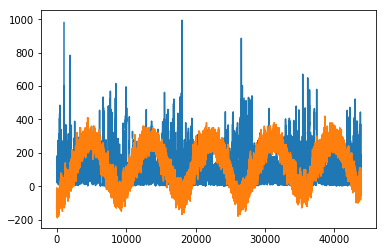

In [20]:
df[TARGET].plot()
(df['TEMP']*10).plot()

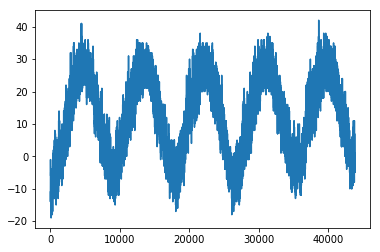

In [15]:
df['TEMP'].plot()

In [17]:
df['year'].unique()

array([2010, 2011, 2012, 2013, 2014], dtype=int64)

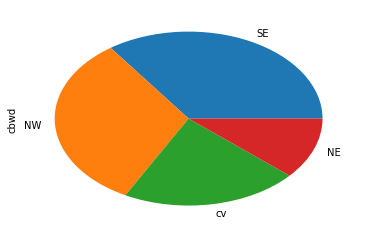

In [25]:
df.cbwd.value_counts().plot.pie()

### 데이터 정제 - 누락데이터 처리, 카테고리->수치형으로 변환

In [29]:
df.isna().sum().sum()/ len(df)

0.04716593647316539

In [30]:
df = df.dropna()
df.shape

(41757, 13)

In [31]:
df.isna().sum().sum()

0

In [32]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [33]:
df_dummy = pd.get_dummies(df)
df_dummy.shape

(41757, 16)

In [36]:
df_dummy.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


### 불필요한 데이터 삭제

In [37]:
drop_columns = ['No','year','month','day','hour']
df_xy = df_dummy.drop(columns=drop_columns)
df_xy.shape

(41757, 11)

In [38]:
df_xy.head(2)

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
24,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
25,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0


### 전처리 - RNN 모델로 학습시킬 수있도록, X, Y 를 만들기(교사학습)
- 무엇으로 무엇을 예측할 것인가?
- 지난 7주일간의 기상 데이터로부터 내일 24시간동안의 미세먼지 정도를 예측하겠다.
- 7일 * 24시간 * 11개 특징 > 1일 * 24시간 * 1개(pm2.5)
- (7, 24, 11) -> (24, 1)
- (7*24, 11) -> (24, 1)

In [42]:
sequence_x = 7 * 24
sequence_y = 24
len(df_xy)

41757

5시간치의 데이터, 3시간 정보로 다음 2시간의 뭔가를 예측하고 싶다
- 1 x1 
- 2 x1 x2
- 3 x1 x2
- 4 y1 x2
- 5    y2
- 5 - (3+1) + 1 = 2
- 5 - (3+2) + 1 = 1

In [55]:
m = len(df_xy) - (sequence_x + sequence_y) + 1
feature_k = df_xy.shape[-1]
(m, sequence_x, feature_k), (m, sequence_y, 1)

((41566, 168, 11), (41566, 24, 1))

In [57]:
data_x = np.zeros((m, sequence_x, feature_k), np.float32)
data_y = np.zeros((m, sequence_y, 1), np.float32)

In [58]:
df_arr = np.array(df_xy)
df_arr.shape

(41757, 11)

In [67]:
for i in range(m):    
    data_x[i] = df_arr[i:i+sequence_x]
    data_y[i] = df_arr[i+sequence_x:i+sequence_x+sequence_y, 0:1]

### 정규화 ( 0~1 ) - minmax

In [68]:
from sklearn.preprocessing import MinMaxScaler

In [70]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [75]:
data_x_2d = np.reshape(data_x, [-1, feature_k])
scaler_x = scaler_x.fit(data_x_2d)
data_x_2d_normal = scaler_x.transform(data_x_2d)
data_x_normal = np.reshape(data_x_2d_normal, data_x.shape)
data_x_normal.shape, np.min(data_x_normal), np.max(data_x_normal)

((41566, 168, 11), 0.0, 1.0)

In [79]:
scaler_y = scaler_y.fit(data_y[:,:,0])
data_y_normal_2d = scaler_y.transform(data_y[:,:,0])
data_y_normal = np.expand_dims(data_y_normal_2d, -1)

In [80]:
data_y_normal.shape, np.min(data_y_normal), np.max(data_y_normal)

((41566, 24, 1), 0.0, 0.99999994)

### 학습용/테스트용 분리

In [85]:
m_train = 1000
m_test = 1000
x_train = data_x_normal[:m_train]
x_test = data_x_normal[m_train:m_train+m_test]
y_train = data_y_normal[:m_train]
y_test = data_y_normal[m_train:m_train+m_test]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1000, 168, 11), (1000, 168, 11), (1000, 24, 1), (1000, 24, 1))

### RNN 모델을 구현

- 3차원 시계열 데이터 시퀀스 길이 7일 * 24시간 = 168 시간
- 커널의 길이 7, 스트라이드 3, 정보 인코딩 32 output
- convolution 1d
- RNN - 셀선택 : RNN, 'GRU', LSTM , 인코딩 32 output
- RNN 의 마지막 시퀀스 output > FC > 24개의 미세먼지 농도 예측

In [89]:
import tensorflow as tf
import tensorflow.contrib.slim as slim

In [93]:
def model(x):
    net = slim.conv1d(x, 32, 7, 3)
    print('net', net)
    cell = tf.keras.layers.GRUCell(32)
    outputs, state = tf.nn.dynamic_rnn(cell, net, dtype=tf.float32) #outputs (m, 168/3, 32)
    output_last = outputs[:, -1]
    out = slim.fully_connected(output_last, sequence_y)
    return out

In [128]:
PX = tf.placeholder(tf.float32, [None, sequence_x, feature_k])
PY = tf.placeholder(tf.float32, [None, sequence_y, 1])
PY_2d = PY[:,:,0]
h = model(PX)
print('h',h)
cost = tf.reduce_mean(tf.square(h - PY_2d))
opt = tf.train.GradientDescentOptimizer(0.1)
train_op = opt.minimize(cost)
r2 = 1 - tf.reduce_sum(tf.square(PY_2d-h))/tf.reduce_sum(tf.square(PY_2d-tf.reduce_mean(PY_2d)))

net Tensor("Conv_5/Relu:0", shape=(?, 56, 32), dtype=float32)
h Tensor("fully_connected_5/Relu:0", shape=(?, 24), dtype=float32)


In [ ]:
gpu_options = tf.GPUOptions(visible_device_list="1")
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

In [144]:
for iter in range(1500):
    _, _cost, _r2 = sess.run([train_op, cost, r2], {PX:x_train, PY:y_train})
    if iter%100==0:
        _r2_e = sess.run(r2, {PX:x_test, PY:y_test})
        print('%d cost:%.5f, r2 train:%.2f, r2 test:%2.f' %(iter, _cost, _r2, _r2_e))

0 cost:0.00880, r2 train:-0.02, r2 test:-0
100 cost:0.00876, r2 train:-0.02, r2 test:-0
200 cost:0.00873, r2 train:-0.02, r2 test:-0
300 cost:0.00869, r2 train:-0.01, r2 test:-0
400 cost:0.00866, r2 train:-0.01, r2 test:-0
500 cost:0.00863, r2 train:-0.00, r2 test:-0
600 cost:0.00861, r2 train:-0.00, r2 test:-0
700 cost:0.00858, r2 train:0.00, r2 test:-0
800 cost:0.00856, r2 train:0.00, r2 test:-0
900 cost:0.00854, r2 train:0.01, r2 test:-0
1000 cost:0.00852, r2 train:0.01, r2 test:-0
1100 cost:0.00849, r2 train:0.01, r2 test:-0
1200 cost:0.00848, r2 train:0.01, r2 test:-0
1300 cost:0.00846, r2 train:0.02, r2 test:-0
1400 cost:0.00844, r2 train:0.02, r2 test:-0


### 시각화 - 정답과 예측

In [145]:
h_train = sess.run(h, {PX:x_train})

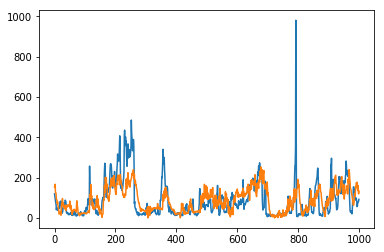

In [146]:
hour = 6
y_train_inverse = scaler_y.inverse_transform(y_train[:,:,0])
h_train_inverse = scaler_y.inverse_transform(h_train[:,:])

plt.plot(y_train_inverse[:,hour])
plt.plot(h_train_inverse[:,hour])

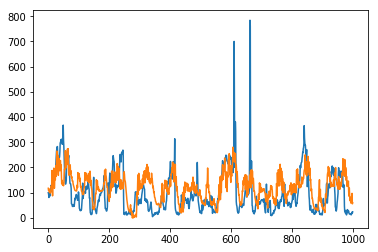

In [147]:
h_test = sess.run(h, {PX:x_test})
y_test_inverse = scaler_y.inverse_transform(y_test[:,:,0])
h_test_inverse = scaler_y.inverse_transform(h_test[:,:])

plt.plot(y_test_inverse[:,hour])
plt.plot(h_test_inverse[:,hour])